In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import pylab
import numpy as np
import copy,os,glob
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import pandas as pd
import seaborn as sns
% matplotlib inline

In [2]:
mesh = nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/mesh_files/mesh_mask_rm1Canada.nc')

In [3]:
mbathy = mesh.variables['mbathy'][0,600,300]
gdept = mesh.variables['gdept'][0,:mbathy,600,300]
gdepw = mesh.variables['gdepw'][0,:mbathy,600,300]
e3t = mesh.variables['e3t'][0,:mbathy,600,300]
e3w = mesh.variables['e3w'][0,:mbathy+1,600,300]

In [4]:
ice = nc.Dataset('/ocean/xiaoxiny/research/data/forcing/Ice_nt/ANHA4-ENG3_icemod_y2003m09.nc')
ice = ice.variables['ileadfra'][600,300]
print (ice)
ice = 0.0

xd = nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_diss.nc')
xd = xd.variables['Th_diss'][0,:mbathy,600,300]

xp = nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_part.nc')
xp = xp.variables['Th_part'][0,:mbathy,600,300]

0.96


In [5]:
gdept[17]

47.373688

In [6]:
# time info
dt  =  1./365/24/3600*10800
t  =  0.0
tmax  =  500  #run for 200 years

In [7]:
# initialize tracer profiles
xd_ = np.copy(xd)
xp_ = np.copy(xp)

anew = np.zeros(xd.shape)
bnew = np.zeros(xd.shape)
cnew = np.zeros(xd.shape)

In [8]:
# initialize the baseshape, with maximum shows up at around 50m

baseshape = np.zeros(gdept.shape)
# for the first 17 layers (the first 47.37m), function increases from 0.5 to 1
baseshape[0:18] = np.linspace(0.5,1,18)  
# decreases from 1 to 0.5 for deeper layers
baseshape[18:]  = np.linspace(1,0.5,len(gdept)-18)

In [9]:
S  =  np.zeros(gdept.shape)
k_ad  =  np.zeros(gdept.shape)

Q  =  0.00246 
#desorption constants
k_de  =  1.5     
                 
#sinking rate/adsorption constants
S[:]  = (-655*ice+1763)*baseshape[:]   
k_ad[:]  =  (-0.07*ice+0.098)*baseshape[:]

#### Assume both s and k change with depth.

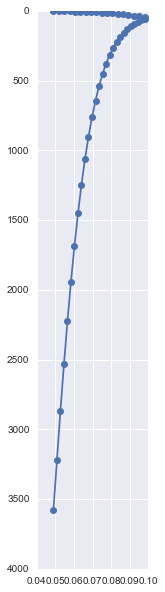

In [10]:
# plot the shape of k
fig = plt.figure(figsize = [2,10])
plt.plot(k_ad,gdept,'-o')
plt.gca().invert_yaxis()

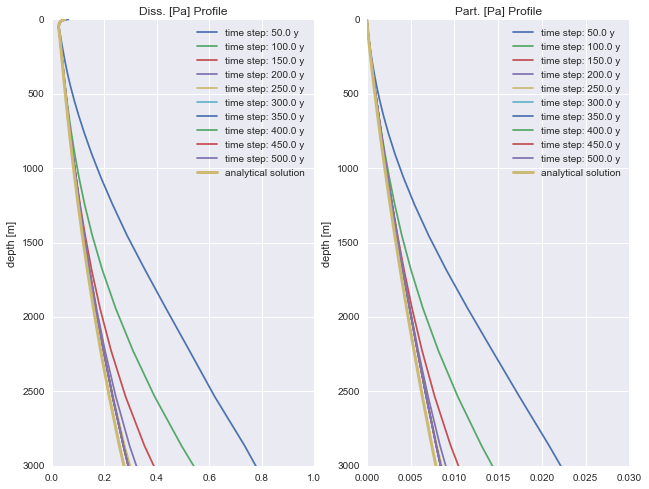

In [11]:
n = 0;pylab.figure(2, figsize  =  (16, 8));sns.set_style("darkgrid")

while (t < tmax):  

    # the surface BC.
    i = 0                         
    anew[i]  =  xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt
    bnew[i]  =  0

    # loop through other depths
    i +=  1
    while (i <=  mbathy-1):    
        
        # forward difference
        anew[i]  =  xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt

        bnew[i]  =  xp_[i] + ((S[i-1]*xp_[i-1]-S[i]*xp_[i])/e3t[i] 
                  + k_ad[i]*xd_[i] - k_de*xp_[i]) * dt
        
        i +=  1

    # store the updated solution
    xd_[:]  =  anew[:]
    xp_[:]  =  bnew[:]

    t +=  dt

    n +=  1
    if n%(2920*50) == 0:

        # plot dissolved and particulate every 50 years
        pylab.subplot(131)
        pylab.plot(xd_, gdept,label =  'time step: %s y'%(n/2920))
        pylab.subplot(132)
        pylab.plot(xp_, gdept,label =  'time step: %s y'%(n/2920))


    
# calculate analytical solution
x = gdept
yp = Q/S*x
yd = Q/k_ad[:]+k_de/k_ad[:]*yp    
    
# label and scale plots
pylab.figure(2, figsize  =  (16, 8))
pylab.subplot(131)
pylab.ylabel('depth [m]')
pylab.title('Diss. [Pa] Profile')
pylab.plot(yd,x,lw = 3,label = 'analytical solution')
pylab.ylim(0,3000)
plt.legend(loc = 0)

pylab.gca().invert_yaxis()

pylab.subplot(132)
pylab.ylabel('depth [m]')
pylab.title('Part. [Pa] Profile')
pylab.plot(yp,x,lw = 3,label = 'analytical solution')
pylab.ylim(0,3000)
plt.legend(loc = 0)
pylab.gca().invert_yaxis()



In [12]:
# compare the result above with data in Canada Basin in 2007 & 2015

In [13]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/total/T*.csv'))
print("found *.csv file: \n{}".format(nc_filename))

found *.csv file: 
['/ocean/xiaoxiny/research/data/total/Total_r1.csv', '/ocean/xiaoxiny/research/data/total/Total_r2.csv', '/ocean/xiaoxiny/research/data/total/Total_r3.csv', '/ocean/xiaoxiny/research/data/total/Total_r4.csv', '/ocean/xiaoxiny/research/data/total/Total_r5.csv', '/ocean/xiaoxiny/research/data/total/Total_r6.csv']


In [14]:
# prepare data for 2015
th230_cb2=[0.091,0.144,0.136,0.133,0.162,0.192]
pa231_cb2=[0.010,0.015,0.028,0.025,0.058,0.020]
depth_cb2=[1345,1000,800,700,500,400]
th230_cb3=[0.565,0.532,0.550,0.479,0.498,0.488,0.387,0.293,0.259]
pa231_cb3=[0.174,0.171,0.238,0.155,0.089,0.096,0.058,0.035,0.033]
depth_cb3=[3500,3000,2500,2000,1400,1400,1000,600,400]
th230_cb4=[0.519,0.516,0.371,0.456,0.282,0.293,0.156,0.104,0.197]
pa231_cb4=[0.169,0.240,0.104,0.133,0.085,0.088,0.060,0.048,0.049]
depth_cb4=[3500,3000,2500,2000,1400,1400,1000,600,400]
ap=[265,275,305]
bp=[180,210,190]

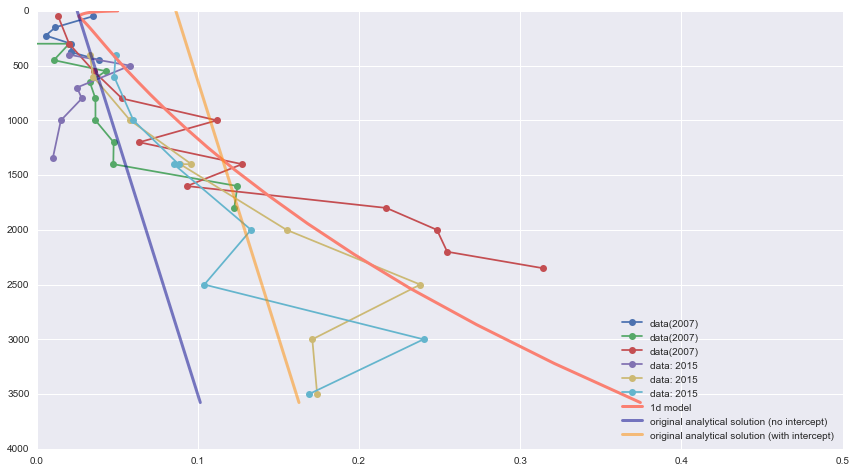

In [17]:
sns.set_style("darkgrid")
fig= plt.figure(figsize=(12,10/3*2))
for j in range(len(nc_filename)-3):
    #read observation in 2007
    data=pd.read_csv(nc_filename[j])
    y= data['depth'].values;
    x=data['231 tot.'].values;
    if j<3:
        plt.plot(x,y,'-o',label='data(2007)')
        
    
# data in 2015    
plt.plot(pa231_cb2,depth_cb2,'o-',label='data: 2015')

plt.plot(pa231_cb3,depth_cb3,'o-',label='data: 2015')  

plt.plot(pa231_cb4,depth_cb4,'o-',label='data: 2015')
 
pylab.plot(xd_, gdept,lw=3, color='salmon',label =  '1d model')

# calculate the original analytical solution
s_  = (-655*ice+1763)
k_  =  (-0.07*ice+0.098)
orig_ana = Q/k_ + k_de/k_*(Q/s_)*gdept
pylab.plot(orig_ana, gdept,lw=3, color='darkblue',label =  'original analytical solution (no intercept)', alpha = 0.5)
orig_ana = Q/k_ + k_de/k_*((Q/s_)*gdept+0.004)
pylab.plot(orig_ana, gdept,lw=3, color='darkorange',label =  'original analytical solution (with intercept)', alpha = 0.5)

plt.legend(loc=4)
plt.xlim(0,0.5);plt.ylim(0,4000); plt.gca().invert_yaxis()
plt.tight_layout()

In [18]:
# change to sea ice concentration to 0.5, run the model again and then compare with data in Eurasian Basin back to 1991

In [19]:
ice =0.5

#sinking rate/adsorption constants
S[:]  = (-655*ice+1763)*baseshape[:]   
k_ad[:]  =  (-0.07*ice+0.098)*baseshape[:]

In [20]:
dt  =  1./365/24/3600*10800
t  =  0.0
tmax  =  500  #run for 200 years

# initialize tracer profiles
xd_ = np.copy(xd)
xp_ = np.copy(xp)

anew = np.zeros(xd.shape)
bnew = np.zeros(xd.shape)
cnew = np.zeros(xd.shape)

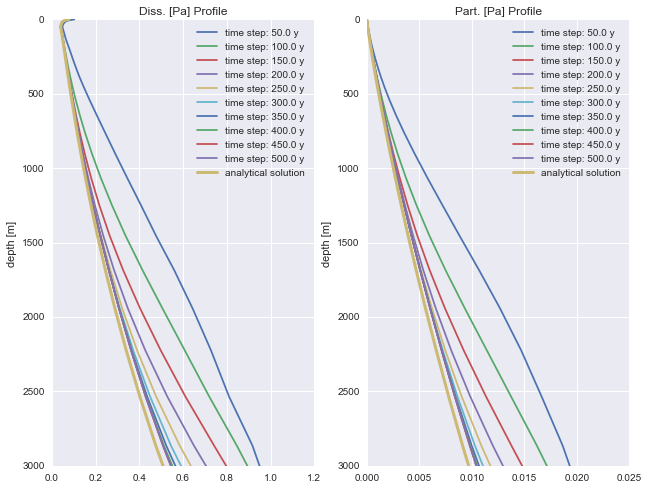

In [21]:
n = 0;pylab.figure(2, figsize  =  (16, 8));sns.set_style("darkgrid")

while (t < tmax):  

    # the surface BC.
    i = 0                         
    anew[i]  =  xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt
    bnew[i]  =  0

    # loop through other depths
    i +=  1
    while (i <=  mbathy-1):    
        
        # forward difference
        anew[i]  =  xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt

        bnew[i]  =  xp_[i] + ((S[i-1]*xp_[i-1]-S[i]*xp_[i])/e3t[i] 
                  + k_ad[i]*xd_[i] - k_de*xp_[i]) * dt
        
        i +=  1

    # store the updated solution
    xd_[:]  =  anew[:]
    xp_[:]  =  bnew[:]

    t +=  dt

    n +=  1
    if n%(2920*50) == 0:

        # plot dissolved and particulate every 50 years
        pylab.subplot(131)
        pylab.plot(xd_, gdept,label =  'time step: %s y'%(n/2920))
        pylab.subplot(132)
        pylab.plot(xp_, gdept,label =  'time step: %s y'%(n/2920))

# calculate analytical solution
x = gdept
yp = Q/S*x
yd = Q/k_ad[:]+k_de/k_ad[:]*yp    
    
# label and scale plots
pylab.figure(2, figsize  =  (16, 8))
pylab.subplot(131)
pylab.ylabel('depth [m]')
pylab.title('Diss. [Pa] Profile')
pylab.plot(yd,x,lw = 3,label = 'analytical solution')
pylab.ylim(0,3000)
plt.legend(loc = 0)

pylab.gca().invert_yaxis()

pylab.subplot(132)
pylab.ylabel('depth [m]')
pylab.title('Part. [Pa] Profile')
pylab.plot(yp,x,lw = 3,label = 'analytical solution')
pylab.ylim(0,3000)
plt.legend(loc = 0)
pylab.gca().invert_yaxis()

In [22]:
nc_filename_= sorted(glob.glob('/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/*.csv'))

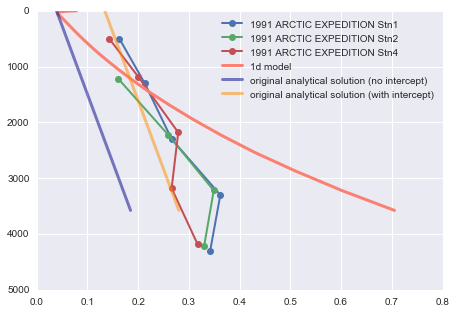

In [23]:
ax = plt.figure(1,figsize=(16,5))

ax = plt.subplot(1,2,2)
#1983,1991
i=0

# read data in Eurasian Basin
for j in ([0,1,3]):
    data=pd.read_csv(nc_filename_[j])
    y= data['depth'].values;
    x= data['231Pa diss.'];

    x=np.ma.masked_where(y<=0,x)
    y=np.ma.masked_where(y<=0,y) 
    name= data['name'][0];    
    plt.plot(x,y,'-o',lw=2,label=name)


# 1d model result (assuming sea ice concentration = 0.5)
pylab.plot(xd_, gdept,lw=3, color='salmon',label =  '1d model')
    
# original analytical solution
s_  = (-655*ice+1763)
k_  =  (-0.07*ice+0.098)
orig_ana = Q/k_ + k_de/k_*(Q/s_)*gdept
pylab.plot(orig_ana, gdept,lw=3, color='darkblue',label =  'original analytical solution (no intercept)', alpha = 0.5)
orig_ana = Q/k_ + k_de/k_*((Q/s_)*gdept+0.004)
pylab.plot(orig_ana, gdept,lw=3, color='darkorange',label =  'original analytical solution (with intercept)', alpha = 0.5)

plt.ylim(0,5000);plt.gca().invert_yaxis()
#label
plt.legend(loc=0)